In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats #had to accept the term and conditions of the competition

 97% 529M/543M [00:05<00:00, 60.8MB/s]
100% 543M/543M [00:05<00:00, 106MB/s] 
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 86.6MB/s]
 95% 258M/271M [00:05<00:00, 46.5MB/s]
100% 271M/271M [00:05<00:00, 53.8MB/s]


In [0]:
!unzip train.zip
!unzip test1.zip

In [0]:
%matplotlib inline

from collections import OrderedDict
import pandas as pd
import torch
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import helper
from skimage import io
from PIL import Image
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [8]:
df = pd.read_csv('sampleSubmission.csv')
df.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
dirpath = os.getcwd()

## Prepare

In [0]:
trainpath = Path(dirpath)/'train'
testpath = Path(dirpath)/'test1'
# !ls {testpath}

In [0]:
class DogCatDataset(Dataset):
    def __init__(self, datafolder, transform):
        self.datafolder = datafolder
        self.image_files_list, self.label_list = zip(*[(s, 1) if s.startswith('cat') 
                                                       else (s, 0) if s.startswith('dog') 
                                                       else (s, -1) for s in os.listdir(datafolder)])
        self.label_list = torch.Tensor(np.array(self.label_list))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder,self.image_files_list[idx])
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.transform(image)
        return image, self.label_list[idx]

In [0]:
valid_size = 0.2

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])


train_data = DogCatDataset(str(trainpath), transform=train_transforms)
test_data = DogCatDataset(str(testpath), transform=test_transforms)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## See the Cute Data

https://matplotlib.org/users/image_tutorial.html

In [0]:
test_iter = iter(testloader)

In [0]:
train_iter = iter(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


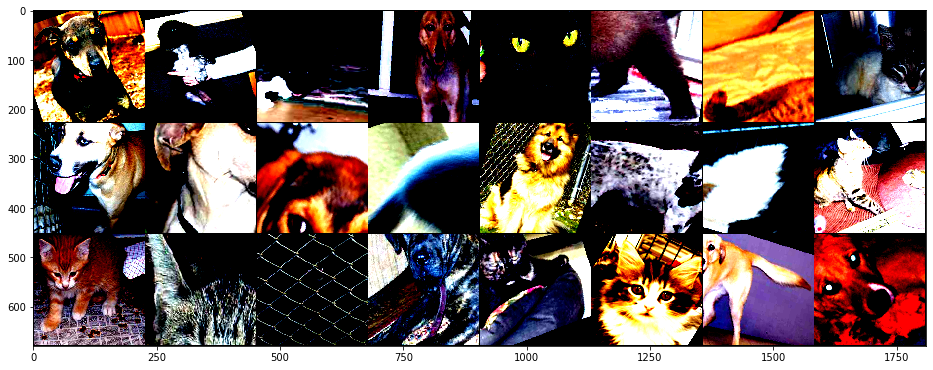

In [16]:
images = next(train_iter)[0][:24]

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(images)
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [0]:
def show(data_iter,test=True, num=5):

    images, labels = next(data_iter)
    
    def denormalize(image):
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        return image
        
    fig, axes = plt.subplots(figsize=(10,4), ncols=num)
    
    for ii in range(num):
        ax = axes[ii]
        img = images[ii].permute((1, 2, 0))
        
        if not test:
            img = denormalize(img)
            
        ax.imshow(img)

        if labels[ii]==1:
          itis="cat"
        elif labels[ii]==0:
          itis="dog"
        else:
          itis="unknown"

        ax.title.set_text(itis)
        ax.axis('off')

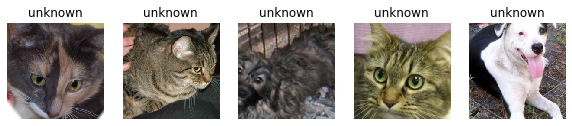

In [18]:
show(test_iter)

## View the various transofrmations on the same batch(better w/o shuffling trainloader)

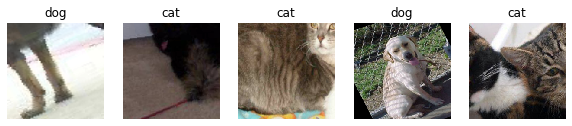

In [19]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

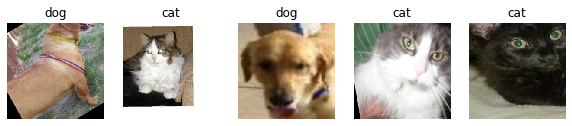

In [20]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

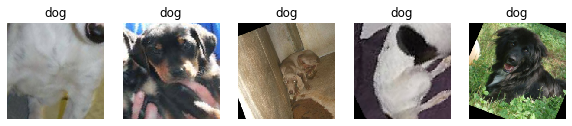

In [21]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

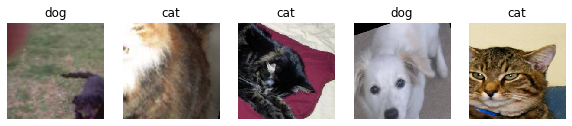

In [22]:
train_iter = iter(trainloader) # to only view the first batch
show(train_iter,test=False)

In [0]:
see = next(train_iter)

In [24]:
see[0].shape

torch.Size([64, 3, 224, 224])

In [25]:
see[1]

tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0.])

In [26]:
see[1].shape

torch.Size([64])

## The Model

In [27]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.8MB/s]


In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
model.fc ##the layer we intend to change

Linear(in_features=512, out_features=1000, bias=True)

In [0]:
for param in model.parameters():
  param.requires_grad=False

In [0]:
fc = nn.Sequential(OrderedDict([
                                
      ('fc1',nn.Linear(512,100)),
      ('relu',nn.ReLU()),
      ('fc2',nn.Linear(100,2))

]))

In [0]:
model.fc = fc

In [33]:
model.fc

Sequential(
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [34]:
for name,param in model.named_parameters():
  if param.requires_grad:
    print(name)

fc.fc1.weight
fc.fc1.bias
fc.fc2.weight
fc.fc2.bias


In [0]:
model = model.cuda()

In [0]:
optimizer = optim.Adam(model.fc.parameters(),0.001)

In [0]:
criterion = nn.CrossEntropyLoss()

## Utils

In [0]:
def num_correct(preds,labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
def accuracy(preds,labels):
  return num_correct(preds,labels)*100.0/len(preds)

## Train

In [0]:
# (model(see[0].cuda())>=0.5).sum()

In [0]:
device = 'cuda'

In [0]:
num_epochs = 5
count = 0
iteration_list = []
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [43]:
for epoch in range(1,num_epochs+1):
  
  train_loss = 0
  train_correct = 0
  train_num = 0

  for i,(images,labels) in enumerate(trainloader):

    ##--------------------------training--------------------------
    model.train()
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)
    output = model(images)
    # print(labels,output)
    # print(labels.shape)
    loss   = criterion(output,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count+=1
    train_loss+=loss.item()
    train_num+=len(labels)
    train_correct+=num_correct(output,labels)

    ##--------------------------validating--------------------------
    if count%20==0:
      valid_loss = 0
      valid_correct = 0
      valid_num = 0 
      with torch.no_grad():
        model.eval()
        for images,labels in validloader:
          images = images.to(device)
          labels = labels.type(torch.LongTensor).to(device)
          output = model(images)
          loss   = criterion(output,labels)

          valid_loss+=loss.item()
          valid_correct+=num_correct(output,labels)
          valid_num+=len(labels)
      valid_loss/=len(validloader)
      valid_correct/=float(valid_num)

      iteration_list.append(count)
      train_loss_list.append(train_loss/count)
      valid_loss_list.append(valid_loss)
      train_acc_list.append(100.0*train_correct/float(train_num))
      valid_acc_list.append(100.0*valid_correct)

      if count%50==0:
        print("Iter {} Epoch {}  train loss: {:.2f}  train acc: {:.2f} valid loss: {:.2f}  valid acc: {:.2f}"
        .format(i,epoch,train_loss_list[-1],train_acc_list[-1],valid_loss_list[-1],valid_acc_list[-1]))

print("Training Over!")

Iter 99 Epoch 1  train loss: 0.26  train acc: 88.67 valid loss: 0.17  valid acc: 92.36
Iter 199 Epoch 1  train loss: 0.21  train acc: 90.61 valid loss: 0.17  valid acc: 92.18
Iter 299 Epoch 1  train loss: 0.20  train acc: 91.39 valid loss: 0.15  valid acc: 93.46
Iter 86 Epoch 2  train loss: 0.04  train acc: 92.74 valid loss: 0.14  valid acc: 93.64
Iter 186 Epoch 2  train loss: 0.07  train acc: 92.27 valid loss: 0.14  valid acc: 93.80
Iter 286 Epoch 2  train loss: 0.08  train acc: 92.42 valid loss: 0.14  valid acc: 93.28
Iter 73 Epoch 3  train loss: 0.02  train acc: 92.84 valid loss: 0.16  valid acc: 92.82
Iter 173 Epoch 3  train loss: 0.04  train acc: 92.53 valid loss: 0.15  valid acc: 93.08
Iter 273 Epoch 3  train loss: 0.05  train acc: 92.76 valid loss: 0.13  valid acc: 94.20
Iter 60 Epoch 4  train loss: 0.01  train acc: 92.88 valid loss: 0.14  valid acc: 93.62
Iter 160 Epoch 4  train loss: 0.02  train acc: 92.62 valid loss: 0.14  valid acc: 94.38
Iter 260 Epoch 4  train loss: 0.03  

In [0]:
filename_pth = 'ckpt_resnet18_catdog.pth'
torch.save(model.state_dict(), filename_pth)

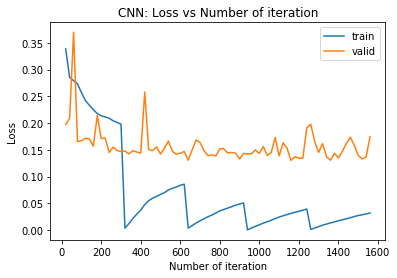

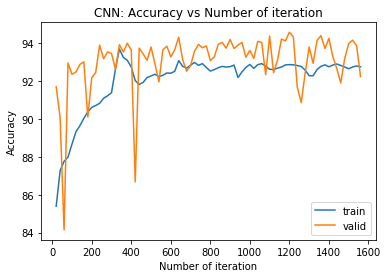

In [45]:
# visualization loss 
plt.plot(iteration_list,train_loss_list,label='train')
plt.plot(iteration_list,valid_loss_list,label='valid')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,train_acc_list,label='train')
plt.plot(iteration_list,valid_acc_list,label='valid')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.legend()
plt.show()

## See predictions

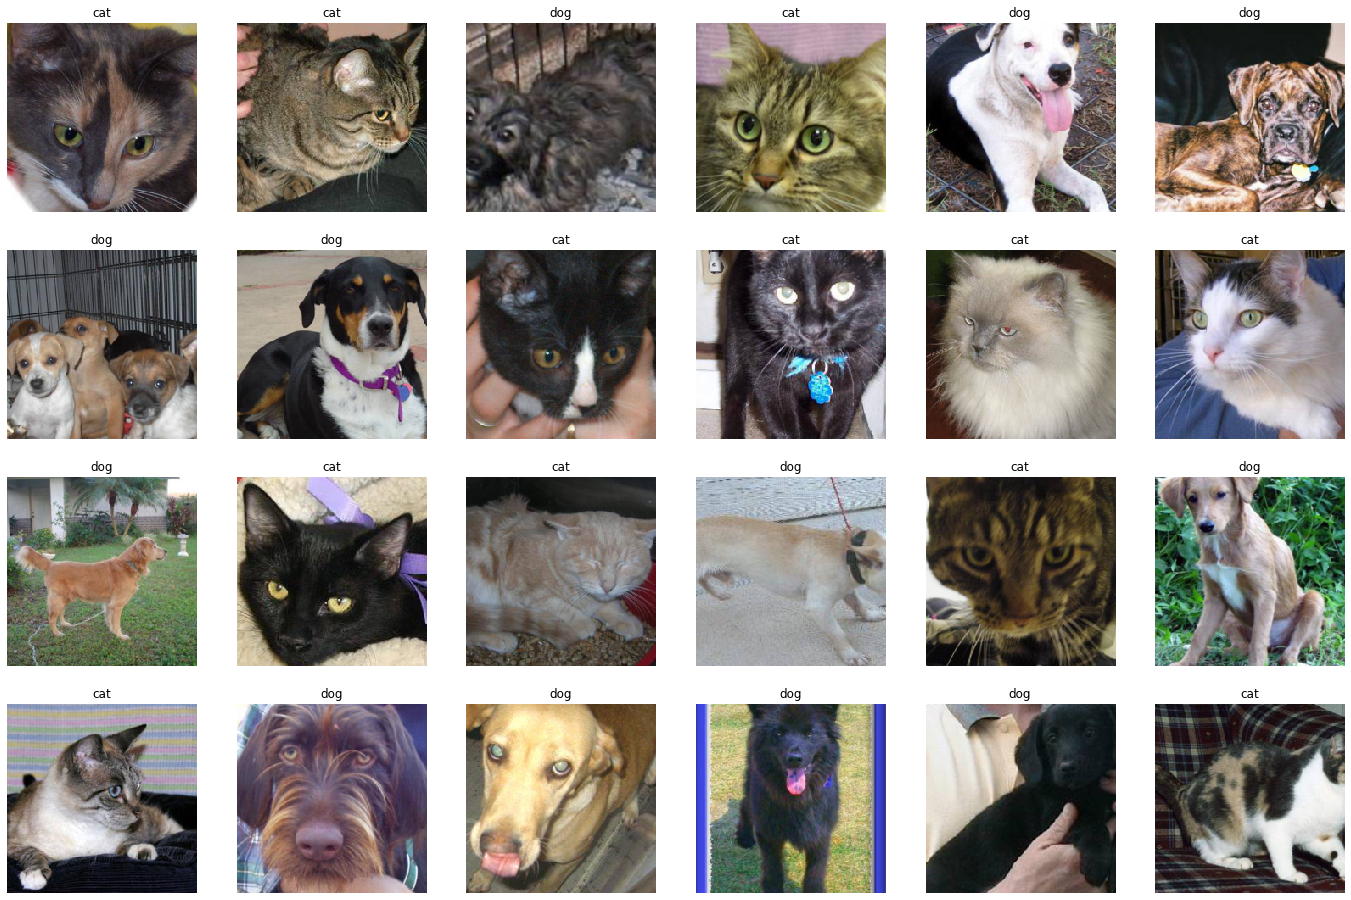

In [49]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {1:'cat', 0:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

## Prediction

In [50]:
len(train_data), len(test_data)

(25000, 12500)

In [0]:
def get_all_preds(model, loader):
  all_preds = torch.tensor([]).to('cuda')
  for images, labels in loader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    preds = model(images)
    all_preds = torch.cat((all_preds,preds),dim=0) #appending the predictions
  return all_preds

In [0]:
with torch.no_grad():
  preds = get_all_preds(model,testloader)
  preds.shape

In [53]:
df.label = preds.squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [54]:
df.label.sum()/len(df)

tensor(-1.3652, device='cuda:0')

In [0]:
df.to_csv('submit.csv')

## More Transfer Learning
- https://www.kaggle.com/beastlyprime/pytorch-beginner-transfer-learning (pytorch with inception net: has 2 outputs)
- https://www.kaggle.com/gpreda/cats-or-dogs-using-cnn-with-transfer-learning (keras)
- https://www.kaggle.com/bulentsiyah/dogs-vs-cats-classification-vgg16-fine-tuning (keras)
## svm
- https://www.kaggle.com/vanausloos/solution-dogs-vs-cats-svm-model-model-2